In [ ]:
#!/usr/bin/env python
# coding: utf-8

# This script is used to compare ensemble outputs with NLDAS data

from mpl_toolkits.basemap import Basemap
from pyproj import Proj
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr
import datetime


def read_ens(out_forc_name_base, metric, start_yr, end_yr):
    for yr in range(start_yr, end_yr+1):        
        
        file = os.path.join(out_forc_name_base + '.' + str(yr) + '.'+metric+'.nc')
        f=xr.open_dataset(file)
        time = f['time'][:]
        pcp = f.variables['pcp'][:]
        tmean = f.variables['t_mean'][:]
        tmin = f.variables['t_min'][:]
        tmax = f.variables['t_max'][:]
        trange = f.variables['t_range'][:]
        
        if yr == start_yr:
            time_concat = time
            pcp_concat = pcp
            tmean_concat = tmean
            tmin_concat = tmin
            tmax_concat = tmax
            trange_concat = trange
        else:
            time_concat = np.concatenate((time_concat,time), axis=0) # (time)
            pcp_concat = np.concatenate((pcp_concat, pcp), axis=0) # (time,y,x)
            tmean_concat = np.concatenate((tmean_concat, tmean), axis=0)
            tmin_concat = np.concatenate((tmin_concat, tmin), axis=0)
            tmax_concat = np.concatenate((tmax_concat, tmax), axis=0)
            trange_concat = np.concatenate((trange_concat, trange), axis=0)
            
    time_concat = pd.DatetimeIndex(time_concat)
        
    return time_concat, pcp_concat, tmean_concat, tmin_concat, tmax_concat, trange_concat

def plot_basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,ax,lat_0,lon_0,ny,nx):

    m = Basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,resolution='l',projection='cyl', ax=ax)   
#     m = Basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,resolution='l',projection='tmerc', ax=ax,lat_0=lat_0,lon_0=lon_0)

    m.drawstates(linewidth=0.25, linestyle='solid', color='grey')
    m.drawcountries(linewidth=0.25, linestyle='solid', color='k')
    m.drawcoastlines(linewidth=0.1, linestyle='solid', color='k')

    # lat and lon with lables
    m.drawparallels(np.arange(np.floor(llcrnrlat),np.ceil(urcrnrlat),10),labels=[True,False,False,False],
                    dashes=[1,1], fontsize=5, linewidth=0.2, color='grey') # 'xx-small', Draw parallels (latitude lines)
    m.drawmeridians(np.arange(np.floor(llcrnrlon),np.ceil(urcrnrlon),15),labels=[False,False,False,True],
                    dashes=[1,1], fontsize=5, linewidth=0.2, color='grey') # 'xx-small', Draw meridians (longitude lines). Label [left, right, top, bottom]

    return m

# set the colormap and centre the colorbar
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar.
    source: http://chris35wills.github.io/matplotlib_diverging_colorbar/
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-300, vmax=1000))    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

#======================================================================================================
# main script
root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet'   
start_yr = 2015
end_yr = 2016

gridinfo_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth.nc')

result_dir = os.path.join(root_dir,'test_uniform_perturb')
test_folders = [d for d in os.listdir(result_dir)]
test_folders = sorted(test_folders)
scenarios_ids = [0,5,8]
intervals = [10,5,2]
scenario_num = len(scenarios_ids)

subforlder = 'gmet_ens_bc_summary'
file_basename = 'ens_forc'

ens_num = 100
time_format = '%Y-%m-%d'

dpi_value = 600
plot_date_start = '2015-01-01'
plot_date_end = '2016-12-31'
plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)

output_dir=os.path.join(root_dir, 'scripts/step20_plot_nldas_stn_std_diff')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_filename = 'step20_plot_nldas_stn_std_diff.png'
    
#======================================================================================================
print('Read gridinfo mask')
# get xy mask from gridinfo.nc
f_gridinfo = xr.open_dataset(gridinfo_file)
mask_xy = f_gridinfo['mask'].values[:] # (y, x). 1 is valid. 0 is invalid.
#data_mask = f_gridinfo['data_mask'].values[:] # (y, x). 1 is valid. 0 is invalid.
latitude = f_gridinfo['latitude'].values[:]
longitude = f_gridinfo['longitude'].values[:]

llcrnrlon=longitude[0,0] #-1
llcrnrlat=latitude[0,0] #-1
urcrnrlon=longitude[-1,-1] #+1
urcrnrlat=latitude[-1,-1] #+1

lat_0=0.5*(llcrnrlat+urcrnrlat)
lon_0=0.5*(llcrnrlon+urcrnrlon)
(ny,nx)=np.shape(longitude)


#======================================================================================================
# read stn_ens std 
print('Read stn ens summary')

for yr in range(start_yr, end_yr+1):
    
    nldas_file = 'ens_forc.sumamry.'+str(yr)+'.nc'
    nldas_path = os.path.join(stn_ens_dir, nldas_file)
    
    f_stn = xr.open_dataset(nldas_path)
    if yr == start_yr:
        pcp_std = f_stn['pcp_std'].values[:] # (time, y, x). unit: mm/day
        tmean_std = f_stn['tmean_std'].values[:] # unit: degC
        tmin_std = f_stn['tmin_std'].values[:] 
        tmax_std = f_stn['tmax_std'].values[:]
        trange_std = f_stn['trange_std'].values[:]
        time = f_stn['time'].values[:]
    else:
        pcp_std = np.concatenate((pcp_std, f_stn['pcp_std'].values[:]), axis = 0)
        tmean_std = np.concatenate((tmean_std, f_stn['tmean_std'].values[:]), axis = 0)
        tmin_std = np.concatenate((tmin_std, f_stn['tmin_std'].values[:]), axis = 0)
        tmax_std = np.concatenate((tmax_std, f_stn['tmax_std'].values[:]), axis = 0)
        trange_std = np.concatenate((trange_std, f_stn['trange_std'].values[:]), axis = 0)
        time = np.concatenate((time, f_stn['time'].values[:]), axis = 0)

# get time mask from nldas data
# time_obj = np.asarray([datetime.datetime.strptime(t, time_format) for t in time])
time_obj = pd.to_datetime(time)
mask_t  = (time_obj >= plot_date_start_obj) & (time_obj <= plot_date_end_obj) 
time = time_obj[mask_t]

# caluclate time mean 
pcp_ensstd_stn = np.nanmean(pcp_std[mask_t,:,:], axis=0)
tmean_ensstd_stn = np.nanmean(tmean_std[mask_t,:,:], axis=0) 
tmin_ensstd_stn = np.nanmean(tmin_std[mask_t,:,:], axis=0) 
tmax_ensstd_stn = np.nanmean(tmax_std[mask_t,:,:], axis=0) 
trange_ensstd_stn = np.nanmean(trange_std[mask_t,:,:], axis=0)

# convert masked values to nan
pcp_ensstd_stn=np.where(mask_xy==0,np.nan,pcp_ensstd_stn)
tmean_ensstd_stn=np.where(mask_xy==0,np.nan,tmean_ensstd_stn)
tmin_ensstd_stn=np.where(mask_xy==0,np.nan,tmin_ensstd_stn)
tmax_ensstd_stn=np.where(mask_xy==0,np.nan,tmax_ensstd_stn)
trange_ensstd_stn=np.where(mask_xy==0,np.nan,trange_ensstd_stn)

del pcp_std,tmean_std,tmin_std,tmax_std,trange_std

#======================================================================================================
# read scenario ensemble results and save to dictionary
print('Read ensemble data')
pcp_std_dict = {} # empty dictionary. will have 3 integer keys for 3 scenarios
tmean_std_dict = {} 
tmin_std_dict = {} 
tmax_std_dict = {} 
trange_std_dict = {} 
# my_dict = {1: 'apple', 2: 'ball'}

for k in range(scenario_num):

    test_folder = test_folders[scenarios_ids[k]]
    
    print(test_folder)
    test_dir = os.path.join(result_dir, test_folder)
    fig_title= test_folder

    print(' -- read spatial ensemble mean')
    # read ensemble mean    
    output_namebase = os.path.join(test_dir,subforlder, file_basename)
    metric = 'ensstd'
    time_ensstd, pcp_ensstd, tmean_ensstd, tmin_ensstd, tmax_ensstd, trange_ensstd = read_ens(output_namebase, metric, start_yr, end_yr)

    # define plot mask for nldas ensemble
    mask_ens_t = (time_ensstd>=plot_date_start_obj) & (time_ensstd<=plot_date_end_obj)
    
    print(' -- calculate temporal mean')
    # caluclate time series mean(ny,nx)
    pcp_ensstd = np.nanmean(pcp_ensstd[mask_ens_t,:,:],axis=0)     
    tmean_ensstd = np.nanmean(tmean_ensstd[mask_ens_t,:,:],axis=0)
    tmin_ensstd = np.nanmean(tmin_ensstd[mask_ens_t,:,:],axis=0)
    tmax_ensstd = np.nanmean(tmax_ensstd[mask_ens_t,:,:],axis=0)
    trange_ensstd = np.nanmean(trange_ensstd[mask_ens_t,:,:],axis=0)
    
    # convert masked values to nan
    pcp_ensstd=np.where(mask_xy==0,np.nan,pcp_ensstd)    
    tmean_ensstd=np.where(mask_xy==0,np.nan,tmean_ensstd)    
    tmin_ensstd=np.where(mask_xy==0,np.nan,tmin_ensstd)    
    tmax_ensstd=np.where(mask_xy==0,np.nan,tmax_ensstd)    
    trange_ensstd=np.where(mask_xy==0,np.nan,trange_ensstd)
    
    # save Ensemble - NLDAS to dictionaries
    pcp_std_dict[k] = pcp_ensstd # empty dictionary. will have 3 integer keys for 3 scenarios
    tmean_std_dict[k] = tmean_ensstd 
    tmin_std_dict[k] = tmin_ensstd
    tmax_std_dict[k] = tmax_ensstd
    trange_std_dict[k] = trange_ensstd    

    del time_ensstd, pcp_ensstd, tmean_ensstd, trange_ensstd 

#======================================================================================================    
# define colorbar range
print('Define colorbar range')
vmin_prcp_std=np.nanmin([np.nanmin(pcp_std_dict[k]) for k in range(scenario_num)])
vmax_prcp_std=np.nanmax([np.nanmax(pcp_std_dict[k]) for k in range(scenario_num)])

vmin_tmean_std=np.nanmin([np.nanmin(tmean_std_dict[k]) for k in range(scenario_num)])
vmax_tmean_std=np.nanmax([np.nanmax(tmean_std_dict[k]) for k in range(scenario_num)])

vmin_tmin_std=np.nanmin([np.nanmin(tmin_std_dict[k]) for k in range(scenario_num)])
vmax_tmin_std=np.nanmax([np.nanmax(tmin_std_dict[k]) for k in range(scenario_num)])

vmin_tmax_std=np.nanmin([np.nanmin(tmax_std_dict[k]) for k in range(scenario_num)])
vmax_tmax_std=np.nanmax([np.nanmax(tmax_std_dict[k]) for k in range(scenario_num)])

vmin_trange_std=np.nanmin([np.nanmin(trange_std_dict[k]) for k in range(scenario_num)])
vmax_trange_std=np.nanmax([np.nanmax(trange_std_dict[k]) for k in range(scenario_num)])

#======================================================================================================    
# plot
print('Plot')
nrow = 5 # prcp, tmean, tmin, tmax, trange
ncol = scenario_num # three scenarios
fig, ax = plt.subplots(nrow, ncol, figsize=(8,8*0.8))#, constrained_layout=True)
# fig.suptitle(fig_title, fontsize='x-small', fontweight='semibold', color='g')
    
for i in range(nrow):
    for k in range(ncol):
        print('subplot ',i,k)
        
        # select data for each subplot
        # PCP (first row)
        if i == 0:
            data=pcp_std_dict[k]
            vmin=vmin_prcp_std
            vmax=vmax_prcp_std
        elif i == 1:
            data=tmean_std_dict[k]
            vmin=vmin_tmean_std
            vmax=vmax_tmean_std
        elif i == 2:
            data=tmin_std_dict[k]
            vmin=vmin_tmin_std
            vmax=vmax_tmin_std
        elif i == 3:
            data=tmax_std_dict[k]
            vmin=vmin_tmax_std
            vmax=vmax_tmax_std
        elif i == 4:
            data=trange_std_dict[k]
            vmin=vmin_trange_std
            vmax=vmax_trange_std

        # plot Basemap
        m = plot_basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,ax[i,k],lat_0,lon_0,ny,nx) # plot Basemap 

        # plot data
#         im1 = m.pcolormesh(longitude,latitude,data,shading='flat',latlon=True,cmap=cmap,vmin=vmin,vmax=vmax)
        cmap= mpl.cm.bwr #mpl.cm.RdBu_r 
        im1 = m.pcolormesh(longitude,latitude,data,shading='flat',latlon=True,cmap=cmap,vmin=vmin, vmax=vmax)

        # set title
        if i == 0:
            title_str = 'Ensemble Std Dev\nScenario '+str(k+1)+' ( interval = '+str(intervals[k])+')'
            ax[i,k].set_title(title_str, fontsize='xx-small', fontweight='semibold')

        # set y-axis label
        y_lables = ['Precip (mm/day)', "T$_{mean}$($^\circ$C)",
                    "T$_{min}$($^\circ$C)","T$_{max}$($^\circ$C)","T$_{range}$($^\circ$C)"]
        if k == 0:
            y_lable = y_lables[i]+'\n\n'
            ax[i,k].set_ylabel(y_lable, fontsize='xx-small')#, fontweight='semibold')
            
        # set colorbar
        if k == ncol-1:
            cbar = fig.colorbar(im1, ax=ax[i,:],orientation='vertical',pad=0.01, shrink=0.9)
            # ax: parent axes from which space for a new colorbar axes will be stolen. 
            #If a list of axes is given they will all be resized to make room for the colorbar axes.
            cbar.ax.tick_params(labelsize=5, length=2, width=1) #'xx-small'
        
        # change subplot border width
        for axis in ['top','bottom','left','right']:
            ax[i,k].spines[axis].set_linewidth(0.5)

# save plot
fig.tight_layout 
fig.savefig(os.path.join(output_dir, output_filename), dpi=dpi_value, bbox_inches = 'tight', pad_inches = 0.05)
plt.close(fig)

print('Done')


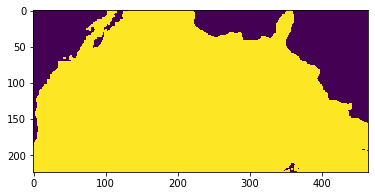

In [4]:
plt.imshow(mask_xy)

In [14]:
plt.imshow(tmean_mean)

(103827, (224, 464))

In [16]:
103827//464,103827%464

(223, 355)

In [17]:
tmin_diff_dict[0][223, 355]

4.713744499321433

In [18]:
mask_xy[223, 355]

1

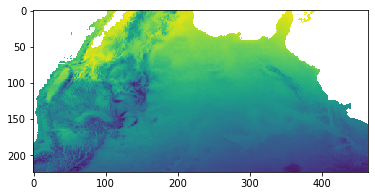

In [28]:
# mask_new = ~np.isnan(tmin_diff_dict[0])
plt.imshow(tmean_mean)

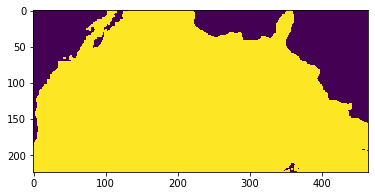

In [23]:
plt.imshow(mask_xy)